# FaX AI with SHAP and AIF360 Data

This example presents how we can use the FaX AI, [AIF360](https://github.com/Trusted-AI/AIF360), and [SHAP](https://github.com/slundberg/shap) libraries together for marrying fairness with explainability.  

We use the COMPAS dataset (using the AIF360 loading methods) and how to train and measure our methods, the methods implemented in the AIF360 library, and sklearn supervised learning methods.

In [71]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing, ExponentiatedGradientReduction, GridSearchReduction
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult, fetch_compas, fetch_german
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference, statistical_parity_difference,equal_opportunity_difference
import matplotlib.pyplot as plt

import shap
import FaX_methods
import aif360_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Training MIM from FaX AI

In [72]:
X_train_compas, X_test_compas, y_train_compas, y_test_compas = aif360_utils.load_compas(subsample=0)
prot_attr = 'race'
#create an MIM model with the COMPAS data
mim_aif = aif360_utils.FaXAIF(X_train_compas, y_train_compas, prot_attr, model_type = 'MIM')

#predict the test data using the model
pred_prob = mim_aif.predict_proba(X_test_compas)
print(pred_prob)
pred = mim_aif.predict(X_test_compas)
print(pred)

[[0.54942862 0.45057138]
 [0.54193477 0.45806523]
 [0.43904907 0.56095093]
 ...
 [0.77934919 0.22065081]
 [0.14618086 0.85381914]
 [0.44280589 0.55719411]]
[0 0 1 ... 0 1 1]


### Measuring MIM using Metrics from sklearn and AIF360

In [73]:
def compute_results(trained_model, X_test_data, y_test_data, prot_attr):
    pred = trained_model.predict(X_test_data)
    acc = accuracy_score(y_test_data, pred)
    di = disparate_impact_ratio(y_test_data, pred, prot_attr=prot_attr)
    dd = statistical_parity_difference(y_test_data, pred, prot_attr=prot_attr)
    eqopp = equal_opportunity_difference(y_test_data, pred, prot_attr=prot_attr)
    eqodd = average_odds_error(y_test_data, pred, prot_attr=prot_attr)

    print("Closer to 1.0 is better metrics")
    print("------------------------------------------------")
    print("Accuracy: ", acc)
    print("Disparate Impact: ", di)
    print()
    print("Closer to 0.0 is better metrics")
    print("------------------------------------------------")
    print("Demographic Disparity: ", dd)
    print("Equal Opportunity: ", eqopp)
    print("Equalized Odds: ", eqodd)
    return [pred, acc, di, dd, eqopp, eqodd]

mim_results = compute_results(mim_aif, X_test_compas, y_test_compas, prot_attr)

Closer to 1.0 is better metrics
------------------------------------------------
Accuracy:  0.6744627054361567
Disparate Impact:  0.6644077652531759

Closer to 0.0 is better metrics
------------------------------------------------
Demographic Disparity:  -0.25306955407137555
Equal Opportunity:  -0.16550918600436149
Equalized Odds:  0.21488632158284812


### Measuring MDE for MIM

In [74]:
XZ = np.hstack((mim_aif.X, mim_aif.Z))
mde_mim = FaX_methods.MDE_ind(XZ)
inf_mim = mde_mim.influence(mim_aif.model, mim_aif.X)
cols = list(X_train_compas.columns)[1:] +[list(X_train_compas.columns)[0]] 
res = {cols[i]: inf_mim[i] for i in range(len(inf_mim))}
print(res)

{'age': 0.12391620861234397, 'juv_fel_count': 0.00119308237385531, 'juv_misd_count': 0.0017889040540852474, 'juv_other_count': 0.013032813882845846, 'priors_count': 0.14828109049671895, 'sex': 0.021154013580946193, 'c_charge_degree_F': 0.018058680327050172, 'race': 0.0}


### Using SHAP with AIF-format Data and FaX AI (MIM) Method

In [22]:
shap_test_samples = shap.sample(X_test_compas.copy(), 500)
mim_shap, mim_expected, mim_explainer = aif360_utils.shap_aif(mim_aif, X_train_compas, shap_test_samples)

  0%|          | 0/500 [00:00<?, ?it/s]

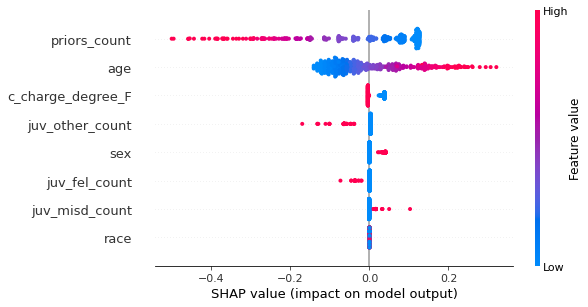

In [23]:
shap.summary_plot(mim_shap, shap_test_samples)

## Logisitic Regression

#### Training and Results with Metrics from sklearn and AIF360

In [75]:
logReg = LogisticRegression()
logReg.fit(X_train_compas, y_train_compas)

logReg_results = compute_results(logReg, X_test_compas, y_test_compas, prot_attr)

Closer to 1.0 is better metrics
------------------------------------------------
Accuracy:  0.6738305941845765
Disparate Impact:  0.6602438784892387

Closer to 0.0 is better metrics
------------------------------------------------
Demographic Disparity:  -0.256766511502395
Equal Opportunity:  -0.1725001006921868
Equalized Odds:  0.21838177892676078


#### MDE Measures for Logistic Regression

In [76]:
XZ = np.hstack((mim_aif.X, mim_aif.Z))
mde_lr = FaX_methods.MDE_ind(XZ,N=100, M=100)
inf_lr = mde_lr.influence(logReg, XZ)

cols = list(X_train_compas.columns)[1:] +[list(X_train_compas.columns)[0]] 
res = {cols[i]: inf_lr[i] for i in range(len(inf_lr))}
print(res)

{'age': 0.07898450212000778, 'juv_fel_count': 0.0010765256977129096, 'juv_misd_count': 0.0021947741752057883, 'juv_other_count': 0.001998161163517266, 'priors_count': 0.24247350467988163, 'sex': 0.009789193170102283, 'c_charge_degree_F': 0.02685796180190344, 'race': 0.014912033403494675}


#### Generating SHAP Explainer and Plotting SHAP Values for Individual Samples

In [26]:
logReg_shap, logReg_expected, logReg_explainer = aif360_utils.shap_aif(logReg, X_train_compas, shap_test_samples)

  0%|          | 0/500 [00:00<?, ?it/s]

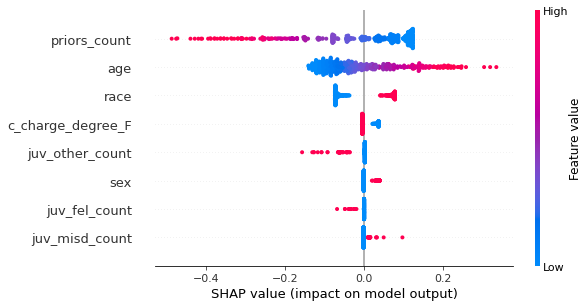

In [27]:
shap.summary_plot(logReg_shap, shap_test_samples)

## Logisitic Regression dropping protected attribute

#### Training and Results with Metrics from sklearn and AIF360

In [9]:
X_train_marginal_compas = X_train_compas.copy()
X_train_marginal_compas[prot_attr] = 0
marg_logReg = LogisticRegression(solver='lbfgs', max_iter=10000)
marg_logReg.fit(X_train_marginal_compas, y_train_compas)
marg_logReg_results = compute_results(marg_logReg, X_test_compas, y_test_compas, prot_attr)

Closer to 1.0 is better metrics
------------------------------------------------
Accuracy:  0.6580278128950695
Disparate Impact:  0.5667270841170503

Closer to 0.0 is better metrics
------------------------------------------------
Demographic Disparity:  -0.2564123321864669
Equal Opportunity:  -0.21050996277266
Equalized Odds:  0.21439468053719968


#### Generating SHAP Explainer and Plotting SHAP Values for Individual Samples

In [10]:
marg_logReg_shap, marg_logReg_expected, marg_logReg_explainer = aif360_utils.shap_aif(marg_logReg, X_train_compas, shap_test_samples)

  0%|          | 0/500 [00:00<?, ?it/s]

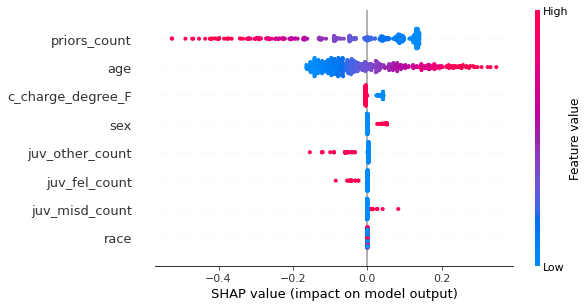

In [11]:
shap.summary_plot(marg_logReg_shap, shap_test_samples)

## Reweighing (Fairness objective: disparate impact)

#### Training and Results with Metrics from sklearn and AIF360

In [12]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='lbfgs', max_iter=10000))
params = {'estimator__C': [1, 10], 'reweigher__prot_attr': [prot_attr]}
clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train_compas, y_train_compas)
clf_results = compute_results(clf, X_test_compas, y_test_compas, prot_attr)

Closer to 1.0 is better metrics
------------------------------------------------
Accuracy:  0.6580278128950695
Disparate Impact:  0.9878028851153601

Closer to 0.0 is better metrics
------------------------------------------------
Demographic Disparity:  -0.005538689873844704
Equal Opportunity:  0.07806233709442623
Equalized Odds:  0.041718821302477116


#### Generating SHAP Explainer and Plotting SHAP Values for Individual Samples

In [13]:
rw_shap, rw_expected, rw_explainer = aif360_utils.shap_aif(clf, X_train_compas, shap_test_samples)

  0%|          | 0/500 [00:00<?, ?it/s]

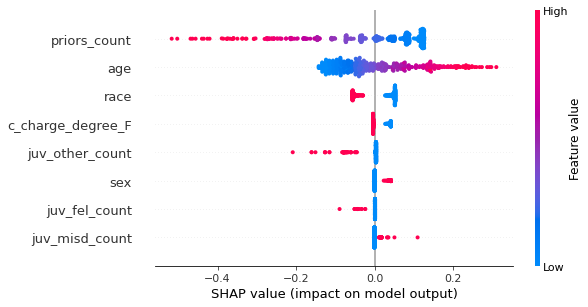

In [14]:
shap.summary_plot(rw_shap, shap_test_samples)

## Exponentiated Gradient Reductions (Fairness objective: disparate impact and treatment)

#### Training and Results with Metrics from sklearn and AIF360

In [15]:
reduction_dp =  aif360_utils.ExponentiatedGradientReductionFix(prot_attr=(prot_attr), estimator=LogisticRegression(solver='lbfgs', max_iter=10000),constraints='DemographicParity')
reduction_dp.fit(X_train_compas, y_train_compas)
reduction_dp_results = compute_results(reduction_dp, X_test_compas, y_test_compas, prot_attr)

Closer to 1.0 is better metrics
------------------------------------------------
Accuracy:  0.515802781289507
Disparate Impact:  0.9906302078019249

Closer to 0.0 is better metrics
------------------------------------------------
Demographic Disparity:  -0.0018585981245362038
Equal Opportunity:  -0.003003504088102793
Equalized Odds:  0.0126891066378379


#### Generating SHAP Explainer and Plotting SHAP Values for Individual Samples

In [16]:
reduction_dp_shap, reduction_dp_expected, reduction_dp_explainer = aif360_utils.shap_aif(reduction_dp, X_train_compas, shap_test_samples)

  0%|          | 0/500 [00:00<?, ?it/s]

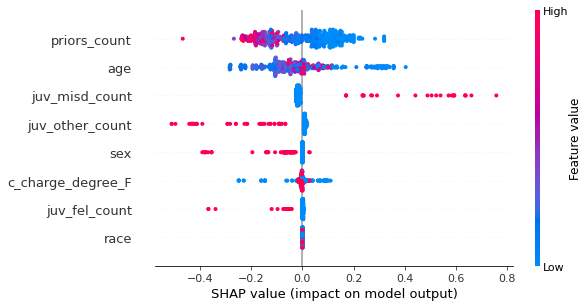

In [17]:
shap.summary_plot(reduction_dp_shap, shap_test_samples)